# NVIDIA GPU Check

This is an example Jupyter Notebook to check the nVIDIA GPUs within ROSA clusters using RH Open Data Science (aka RHODS)

### Import TensorFlow and other libraries

In [18]:
!pip install torch torchvision

In [19]:
import tensorflow as tf

import numpy as np
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

### Check GPUs Available

In [ ]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


2023-06-26 17:50:26.350206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-26 17:50:26.351444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-26 17:50:26.351629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
torch.cuda.is_available() # Do we have a GPU? Should return True.

True

In [4]:
torch.cuda.device_count()  # How many GPUs do we have access to?

1

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) # Check which device we got

cuda:0


In [8]:
torch.cuda.get_device_name(0)

'Tesla T4'

### Test GPU with a simple MNIST Model 

Once you have assigned the first GPU device to your device variable, you are ready to work with the GPU. Let’s start working with the GPU by loading vectors, matrices, and data:

In [11]:
X_train = torch.IntTensor([0, 30, 50, 75, 70]) # Initialize a Tensor of Integers with no device specified
print(X_train.is_cuda, ",", X_train.device) # Check which device Tensor is created on

False , cpu


In [12]:
# Move the Tensor to the device we want to use
X_train = X_train.cuda()
# Alternative method: specify the device using the variable
# X_train = X_train.to(device)
# Confirm that the Tensor is on the GPU now
print(X_train.is_cuda, ",", X_train.device)

True , cuda:0


In [13]:
# Alternative method: Initialize the Tensor directly on a specific device.
X_test = torch.cuda.IntTensor([30, 40, 50], device=device)
print(X_test.is_cuda, ",", X_test.device)

True , cuda:0


After you have loaded vectors, matrices, and data onto a GPU, load a neural network model:

In [20]:
# Here is a basic fully connected neural network built in Torch.
# If we want to load it / train it on our GPU, we must first put it on the GPU
# Otherwise it will remain on CPU by default.

batch_size = 100

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 784)
        self.fc2 = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

In [35]:
model = SimpleNet().to(device)  # Load the neural network model onto the GPU

After the model has been loaded onto the GPU, train it on a data set.  For this example, we will use the FashionMNIST data set:

In [21]:
"""
    Data loading, train and test set via the PyTorch dataloader.
"""
# Transform our data into Tensors to normalize the data
train_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

test_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])

# Set up a training data set
trainset = datasets.FashionMNIST('./data', train=True, download=True,
                                transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

# Set up a test data set
testset = datasets.FashionMNIST('./data', train=False,
                                transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

100%|██████████| 26421880/26421880 [00:01<00:00, 13584060.02it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 295513.83it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4863439.30it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11652604.96it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Once the FashionMNIST data set has been downloaded, you can take a look at the dictionary and sample its content.

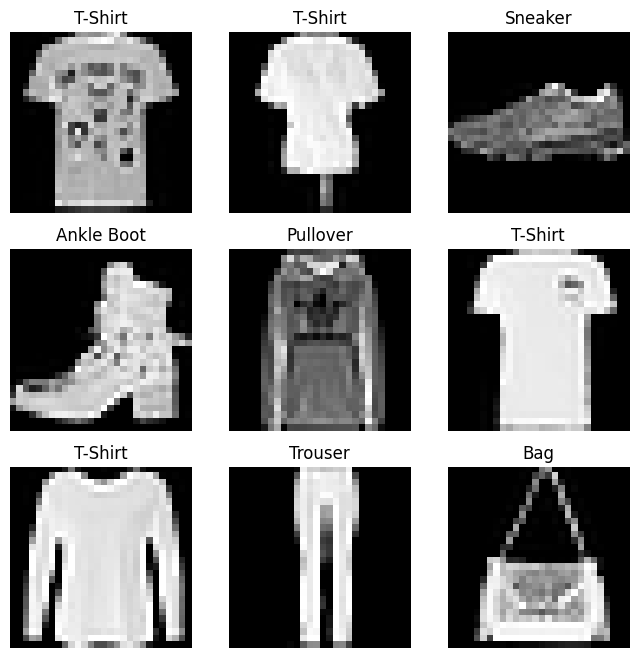

In [25]:
# A dictionary to map our class numbers to their items.
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Plotting 9 random different items from the training data set, trainset.
figure = plt.figure(figsize=(8, 8))
for i in range(1, 3 * 3 + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(3, 3, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.view(28,28), cmap="gray")
plt.show()

There are ten classes of fashion items (e.g. shirt, shoes, and so on).  Our goal is to identify which class each picture falls into. Now you can train the model and determine how well it classifies the items:

In [31]:
def train(model, device, train_loader, optimizer, epoch):
    """Model training function"""
    model.train()
    print(device)
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

In [30]:
def test(model, device, test_loader):
    """Model evaluating function"""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [36]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    # Use the no_grad method to increase computation speed
    # since computing the gradient is not necessary in this step.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [37]:
# number of  training 'epochs'
EPOCHS = 5
# our optimization strategy used in training.
optimizer = optim.Adadelta(model.parameters(), lr=0.01)

The accuracy of the model increases over a number of epochs:

In [39]:
for epoch in range(1, EPOCHS + 1):
        print( f"EPOCH: {epoch}")
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

EPOCH: 1
cuda:0


600it [00:08, 66.85it/s]



Test set: Average loss: -0.5577, Accuracy: 6247/10000 (62%)

EPOCH: 2
cuda:0


600it [00:07, 83.40it/s]



Test set: Average loss: -0.6343, Accuracy: 6961/10000 (70%)

EPOCH: 3
cuda:0


600it [00:06, 86.32it/s]



Test set: Average loss: -0.6707, Accuracy: 7111/10000 (71%)

EPOCH: 4
cuda:0


600it [00:07, 85.68it/s]



Test set: Average loss: -0.6867, Accuracy: 7170/10000 (72%)

EPOCH: 5
cuda:0


600it [00:07, 85.08it/s]



Test set: Average loss: -0.7035, Accuracy: 7398/10000 (74%)



In [40]:
torch.save(model.state_dict(), "mnist_fashion_SimpleNet.pt")